In [1]:
import time
import numpy as np

from typing import Callable, List, Union, Iterator

import diffrax
from diffrax import diffeqsolve, Tsit5, Kvaerno5, ODETerm, SaveAt, PIDController
import equinox as eqx  # https://github.com/patrick-kidger/equinox
from flax import nnx
import optax
import jax
import jax.lax as lax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from jaxtyping import Array, Float  # https://github.com/google/jaxtyping

jax.config.update("jax_enable_x64", True)

from models import NeuralODE, NeuralMetriplecticODE
from system import SystemTrajectoryGenerator, MetriplecticSystem
from utils import load_model

print("JAX devices:", jax.devices())
print("Default backend:", jax.default_backend())

JAX devices: [CpuDevice(id=0)]
Default backend: cpu


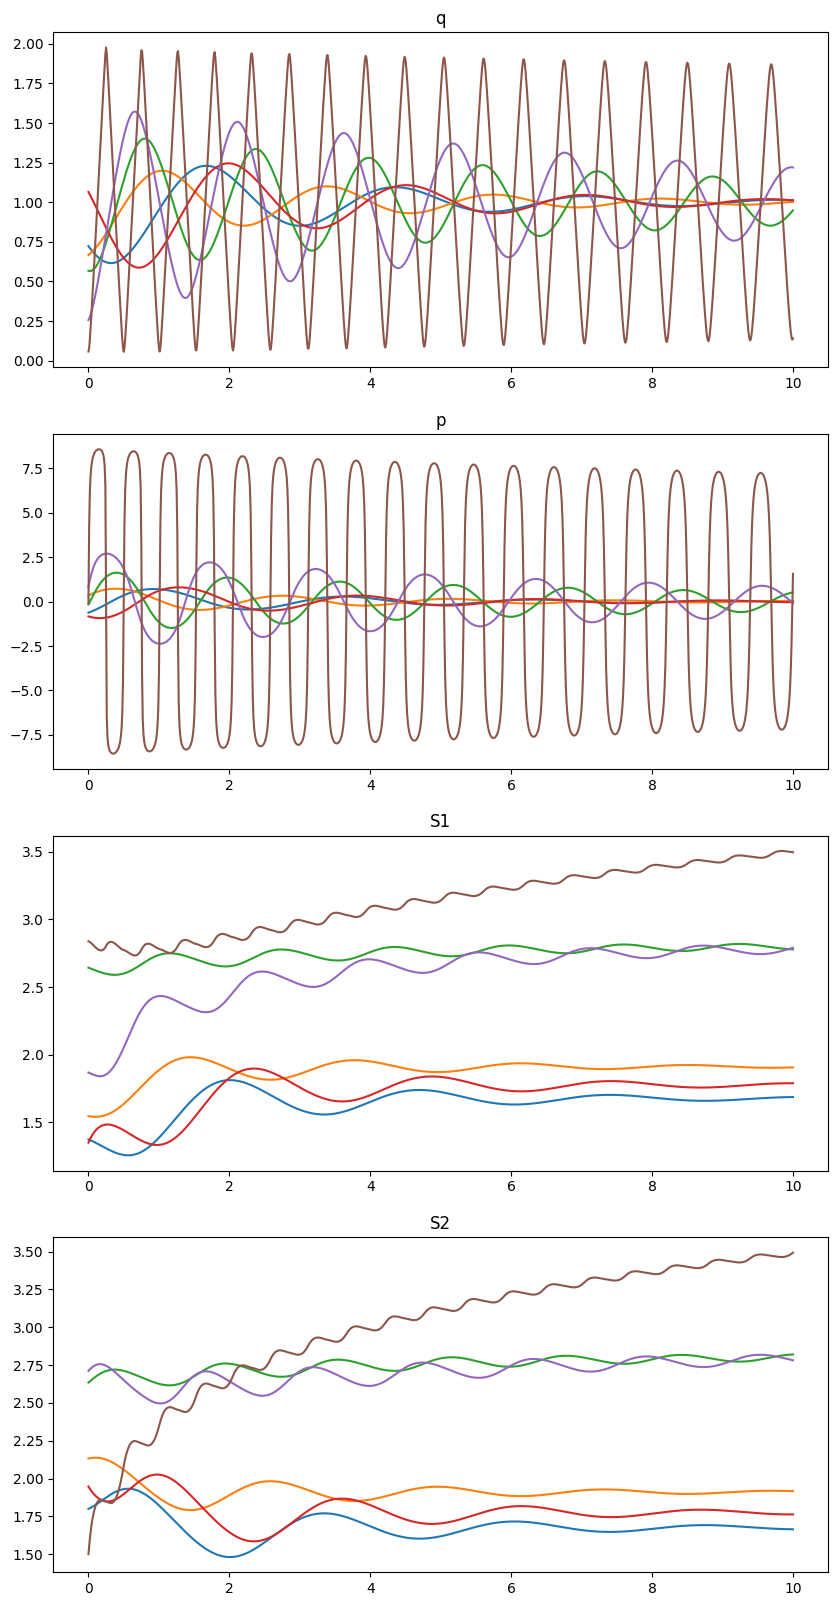

In [2]:
def SackurTetrode(S,Nkb,c_hat,V):
        return jnp.power(jnp.exp(S/Nkb)/(c_hat*V),2.0/3.0)

def M_gas(x, args):
    q, p, S1, S2 = x
    Nkb, m, alpha, L, c_hat, A_char = args
    
    V1 = A_char * q
    V2 = A_char * (2.0 * L - q)
    E1 = SackurTetrode(S1, Nkb, c_hat, V1)
    E2 = SackurTetrode(S2, Nkb, c_hat, V2)
    
    factor = 9.0 * (Nkb**2) * alpha / 4.0
    
    M = jnp.zeros((4, 4), dtype=x.dtype)
    M = M.at[2, 2].set(factor / (E1**2))
    M = M.at[2, 3].set(-factor / (E1 * E2))
    M = M.at[3, 2].set(-factor / (E1 * E2))
    M = M.at[3, 3].set(factor / (E2**2))
    
    return M

def E_gas(x, args):
    q, p, S1, S2 = x
    Nkb, m, alpha, L_, c_hat, A_char = args
    
    E_kin = p**2 / (2 * m)
    
    V1 = A_char * q
    V2 = A_char * (2.0 * L_ - q)
    
    E1 = SackurTetrode(S1, Nkb, c_hat, V1)
    E2 = SackurTetrode(S2, Nkb, c_hat, V2)
    
    return E_kin + E1 + E2

def S_gas(x, args):
    q, p, S1, S2 = x
    return S1 + S2

def L_gas(x, args):
    return jnp.array([
        [0.,  1., 0., 0.],
        [-1., 0., 0., 0.],
        [0.,  0., 0., 0.],
        [0.,  0., 0., 0.],
    ], dtype=x.dtype)

def gradE_gas(x, args):
    return jax.grad(lambda x_: E_gas(x_, args))(x)

def gradS_gas(x, args):
    return jax.grad(lambda x_: S_gas(x_, args))(x)

def two_gas_container(t, y, args):
    L = L_gas(y, args)
    M = M_gas(y, args)
    grad_E = gradE_gas(y, args)
    grad_S = gradS_gas(y, args)
    return L@grad_E + M@grad_S

Nkb = 1 # Number of particles and Boltzmann constant (characteristic unit of entropy)
m = 1 # Mass of wall
alpha = 8 # 
length = 1 # Distance from origin to the middle of the container (equilibrium wall position)
c_hat = 1 # Energy normalization
A_char = 1 # Average cross-sectional area
args = (Nkb, m, alpha, length, c_hat, A_char)

dim = 4
system = MetriplecticSystem([L_gas,M_gas,E_gas,S_gas], dim, Tsit5(), ["q", "p", "S1", "S2"], args)

key = jax.random.PRNGKey(42)
n_traj = 6
y0s = jax.random.uniform(key, (n_traj,dim)) * jnp.array([1.75, 2, 2.0, 2.0]) + jnp.array([0.0, -1.0, 1.0, 1.0])

y = system.generate_trajectories(y0s, 0, 10, 0.01)
system.plot_trajectories()

In [3]:
system = MetriplecticSystem([L_gas,M_gas,E_gas,S_gas], 4, Tsit5(), ["q", "p", "S1", "S2"], args)
model = load_model("/Users/aballester3/Projects/Metriplectic/metriplectic/diffrax-example/two_gas_container/model_checkpoint_final")
#training_data = np.load("/Users/aballester3/Projects/Metriplectic/metriplectic/training_data_norm.npy")
model

NeuralMetriplecticODE(
  func=NeuralMetriplecticForm(
    LdS=GFINNComponent(
      T=MLP(
        layers=(
          Linear(
            weight=f64[32,4],
            bias=f64[32],
            in_features=4,
            out_features=32,
            use_bias=True
          ),
          Linear(
            weight=f64[32,32],
            bias=f64[32],
            in_features=32,
            out_features=32,
            use_bias=True
          ),
          Linear(
            weight=f64[32,32],
            bias=f64[32],
            in_features=32,
            out_features=32,
            use_bias=True
          ),
          Linear(
            weight=f64[32,32],
            bias=f64[32],
            in_features=32,
            out_features=32,
            use_bias=True
          ),
          Linear(
            weight=f64[32,32],
            bias=f64[32],
            in_features=32,
            out_features=32,
            use_bias=True
          ),
          Linear(
            weight=f6

y0 shape:  (10, 4)
y0:  [1.20177854 0.0762731  1.77463682 2.86727315]
y_true shape:  (10, 10000, 4)
y_model shape:  (10, 10000, 4)
Loss:  1.3442598409838316e-09


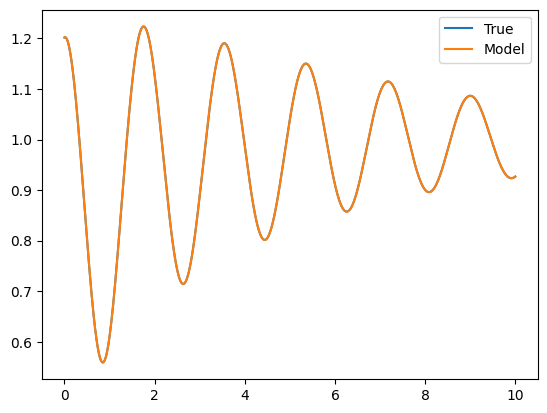

In [4]:
dim = 4
n_sample = 0
n_dim = 0
y0 = jax.random.uniform(key, (10,dim)) * jnp.array([1.0, 0.4, 2.0, 2.0]) + jnp.array([0.5, -0.2, 1, 1])
print("y0 shape: ", y0.shape)
print("y0: ", y0[n_sample,:])
t0 = 0.0
t1 = 10.0
dt = 1e-3
ts = np.linspace(t0,t1,int((t1-t0)/dt))

y_true = system.generate_trajectories(y0, t0, t1, dt)
y_model = jax.vmap(model, in_axes=(None, 0))(ts, y0)

print("y_true shape: ", y_true.shape)
print("y_model shape: ", y_model.shape)
print("Loss: ", jnp.mean((y_true - y_model) ** 2))

plt.plot(ts,y_true[n_sample,:,n_dim], label="True")
plt.plot(ts,y_model[n_sample,:,n_dim], label="Model")
plt.legend()

In [ ]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)
def check_antisymmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, -a.T, rtol=rtol, atol=atol)
def check_positive_semidefinite(a):
    return np.all(np.linalg.eigvals(a) >= 0)
def check_unitary(a, rtol=1e-05, atol=1e-08):
    return np.allclose(np.eye(a.shape[0]), a @ a.T.conj(), rtol=rtol, atol=atol)
Q = model.func.Q_MLP(y0[0,:])
Sigma = model.func.Sigma_MLP(y0[0,:])
U = model.func.U_MLP(y0[0,:])
Lambda = model.func.Lambda_MLP(y0[0,:])
L = Q@Sigma@Q.T
M = U@Lambda@U.T
print("Q (unitary): ", check_unitary(Q))
print(Q)
print("Sigma: \n")
print(Sigma)
print("U(unitary): ", check_unitary(U))
print(U)
print("Lambda: ")
print(Lambda)
print("L (antisymmetric):", check_antisymmetric(L))
print(L)
print("M (symmetric psd): ", (check_symmetric(M),check_positive_semidefinite(M)))
print(M)
print(np.linalg.eigvals(M))

Q (unitary):  True
[[ 0.83426073  0.20192841  0.45278421  0.24128904]
 [-0.36714885  0.71890033  0.04213074  0.58873512]
 [-0.40367441 -0.34765456  0.83873066  0.11275706]
 [ 0.07910576 -0.56704809 -0.29957026  0.76318832]]
Sigma: 

[[ 0.          1.11612843  0.          0.        ]
 [-1.11612843  0.          0.          0.        ]
 [ 0.          0.          0.          1.03685214]
 [ 0.          0.         -1.03685214  0.        ]]
U(unitary):  True
[[ 0.32109607  0.04975126 -0.70303515  0.63258494]
 [-0.20195318  0.39039726 -0.63564706 -0.63463195]
 [ 0.21210789  0.90794846  0.31713905  0.17338589]
 [-0.90062338  0.14402912 -0.03342484  0.40867581]]
Lambda: 
[[0.1547761  0.         0.         0.        ]
 [0.         0.20764709 0.         0.        ]
 [0.         0.         0.64754931 0.        ]
 [0.         0.         0.         0.93114863]]
L (antisymmetric): True
[[-3.96304147e-18  1.01799900e+00 -3.89634894e-01 -1.12590028e-01]
 [-1.01799900e+00  1.26978157e-17 -4.06957609e-02 